# JARVIS EDA

see all datasets here: https://pages.nist.gov/jarvis/databases/

In [1]:
# Imports
import io
import sys
import toml
import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jarvis.db.figshare import data


import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import importlib

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

## Load TOML Configuration

In [2]:
# Configuration
CONFIG_PATH = "config.toml"
config = toml.load(CONFIG_PATH)

# Pretty print configuration
print("Project Configuration:")
pprint.pprint(config)

# Set up system path
SYS_PATH = config.get('system', {}).get('path', './')
sys.path.append(SYS_PATH) # .../code/jarvis/


Project Configuration:
{'data': {'dataset_name': 'dft_3d', 'store_dir': '/shared/data/jarvis'},
 'features': {'bag_of_elements': True,
              'derived': ['eps_mean', 'eps_std'],
              'use_columns': ['ehull',
                              'formation_energy_peratom',
                              'avg_elec_mass',
                              'avg_hole_mass',
                              'effective_masses_297K',
                              'epsx',
                              'epsy',
                              'epsz',
                              'natoms']},
 'filters': {'bandgap_column': 'optb88vdw_bandgap',
             'max_eps': 10.0,
             'min_eps': 1.0,
             'semiconductor_max': 4.0,
             'semiconductor_min': 0.5,
             'toxic_elements': ['Pb', 'Cd', 'Hg', 'As', 'Se'],
             'transparent_min': 3.0},
 'known': {'transparent_formulas': ['In2O3',
                                    'ZnO',
                                   

In [3]:
# Custom Imports and Configurations
from jarvis_utils import load_or_fetch_dataset
from logger_utils import setup_logger, flush_logger
from filter_utils import apply_filters

# Setup logger
logger = setup_logger(config)

logger.info("Project configuration loaded.")
logger.info(f"Dataset: {config['data']['dataset_name']}")
logger.info(f"Store directory: {config['data']['store_dir']}")

# Load dataset
df = load_or_fetch_dataset(config["data"]["dataset_name"], data, config["data"]["store_dir"])
logger.info(f"Dataset shape: {df.shape}")


2025-11-18 20:45:56,129 - jarvis_project - INFO - Project configuration loaded.
2025-11-18 20:45:56,130 - jarvis_project - INFO - Dataset: dft_3d
2025-11-18 20:45:56,131 - jarvis_project - INFO - Store directory: /shared/data/jarvis


Loading existing pickle file: /shared/data/jarvis/jarvis_dft_3d.pkl


2025-11-18 20:45:57,375 - jarvis_project - INFO - Dataset shape: (75993, 64)


Dataset shape: (75993, 64)


In [4]:
features = df.columns.tolist()
logger.info(f"Features: {features}")

2025-11-18 20:45:57,386 - jarvis_project - INFO - Features: ['jid', 'spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom', 'func', 'optb88vdw_bandgap', 'atoms', 'slme', 'magmom_oszicar', 'spillage', 'elastic_tensor', 'effective_masses_300K', 'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut', 'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy', 'mepsz', 'modes', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass', 'icsd', 'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric', 'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond', 'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality', 'efg', 'xml_data_link', 'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'raw_files', 'nat', 'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap', 'reference', 'search']


## Feature Exploration

In [5]:
# Capture df.info() output
buf = io.StringIO()
df.info(buf=buf)
info_str = buf.getvalue()
logger.info("DataFrame info:\n" + info_str)

# The sections below take 56min to run on dft_3d dataset.
'''
# Missing values summary (no missing values for dft_3d dataset)
missing_summary = df.isnull().sum().sort_values(ascending=False).head(20)
logger.info("Top 20 columns with missing values:\n" + str(missing_summary))

# Basic statistics
stats_summary = df.describe(include="all")
logger.info("Basic statistics:\n" + str(stats_summary))
''';

2025-11-18 20:45:57,941 - jarvis_project - INFO - DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75993 entries, 0 to 75992
Data columns (total 64 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   jid                                   75993 non-null  object 
 1   spg_number                            75993 non-null  object 
 2   spg_symbol                            75993 non-null  object 
 3   formula                               75993 non-null  object 
 4   formation_energy_peratom              75993 non-null  float64
 5   func                                  75993 non-null  object 
 6   optb88vdw_bandgap                     75993 non-null  float64
 7   atoms                                 75993 non-null  object 
 8   slme                                  75993 non-null  object 
 9   magmom_oszicar                        75993 non-null  object 
 10  spillage        

## Apply filters

 Filter on Nontoxic and Transparent Semiconductors.

The JARVIS-DFT 3D dataset provides several bandgap fields depending on the functional used:

 - optb88vdw_bandgap: bandgap computed with OptB88vdW functional (most common in this dataset).
 - mbj_bandgap: bandgap computed with TB-mBJ (often more accurate).
 - hse_gap: bandgap computed with HSE hybrid functional (if available).

We use `optb88vdw_bandgap` for our analysis.

- Features for semi-conductivity
    - band gaps: `optb85vdw_bandgap`, `mbj_bandgap`, and `hse_gap`
    - thermodynamic stability: `ehull` and `formation_energy_peratom`
    - electron mobility: `effective_masses_297K`, `avg_elec_mass`, `avg_hole_mass`
    - dielectric properties: `epsx`, `epsy`, `epsz`
     


In [6]:
# Apply filters
df_candidates = apply_filters(df, config)

## Profiling and Visualization

Profile the candidates:
 - Distribution of bandgaps within the 2,059 materials.
 - Which chemistries dominate (oxides, nitrides, sulfides, etc.).
 -Common space groups among transparent semiconductors.

Visualize:
 - Histogram of candidate bandgaps.
 - Scatter plot: bandgap vs density or formation energy.
 - Periodic table heatmap of element frequency in candidates.

Rank by stability:
 - Sort candidates by lowest formation energy per atom.
 - Highlight those with negative formation energies (likely stable).

Cross‑check with experimental datasets:
 - Compare against known transparent semiconductors (ZnO, GaN, AlN, etc.).
 - Validate promising new candidates.

### Bandgap Distribution

Are most candidates clustered near 3-4 eV (transparent semiconductors)?

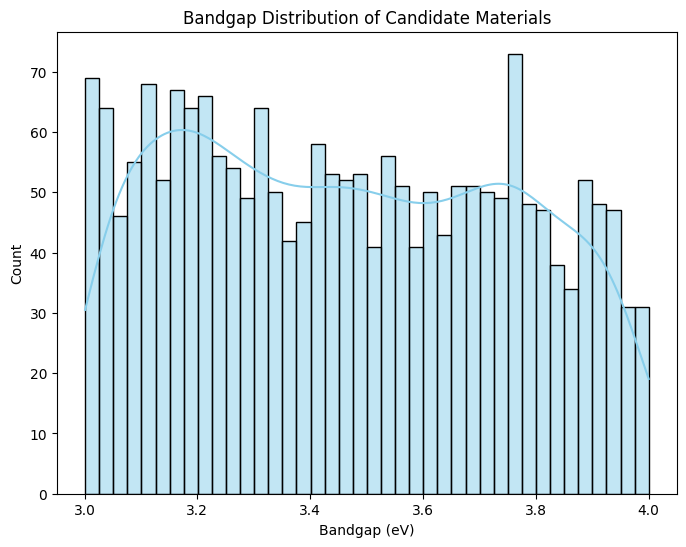

In [7]:

# Bandgap Distribution
plt.figure(figsize=(8,6))
sns.histplot(df_candidates["optb88vdw_bandgap"], bins=40, kde=True, color="skyblue")
plt.title("Bandgap Distribution of Candidate Materials")
plt.xlabel("Bandgap (eV)")
plt.ylabel("Count")
plt.show()



### Formation Energy vs Bandgap

Which candidates combine transparency with negative formation energy (likely stable)?

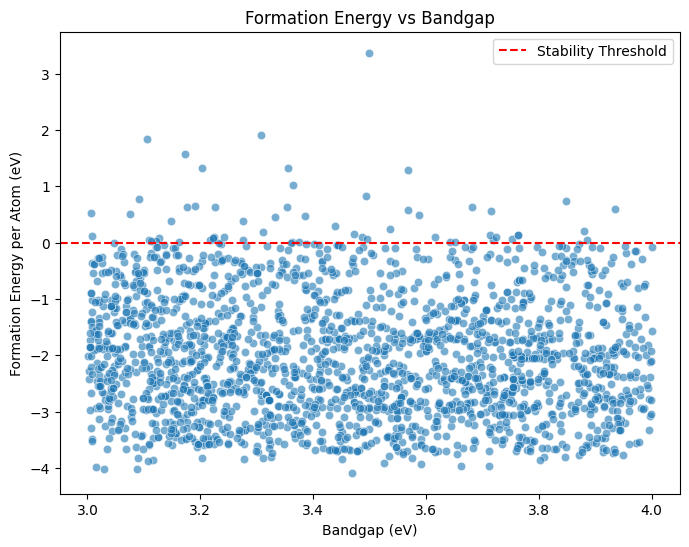

In [8]:
# Formation Energy vs Bandgap
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_candidates, x="optb88vdw_bandgap", y="formation_energy_peratom", alpha=0.6)
plt.title("Formation Energy vs Bandgap")
plt.xlabel("Bandgap (eV)")
plt.ylabel("Formation Energy per Atom (eV)")
plt.axhline(0, color="red", linestyle="--", label="Stability Threshold")
plt.legend()
plt.show()


### Element Frequency in Candidates

Which elements dominate (likely oxides, nitrides, fluorides)?

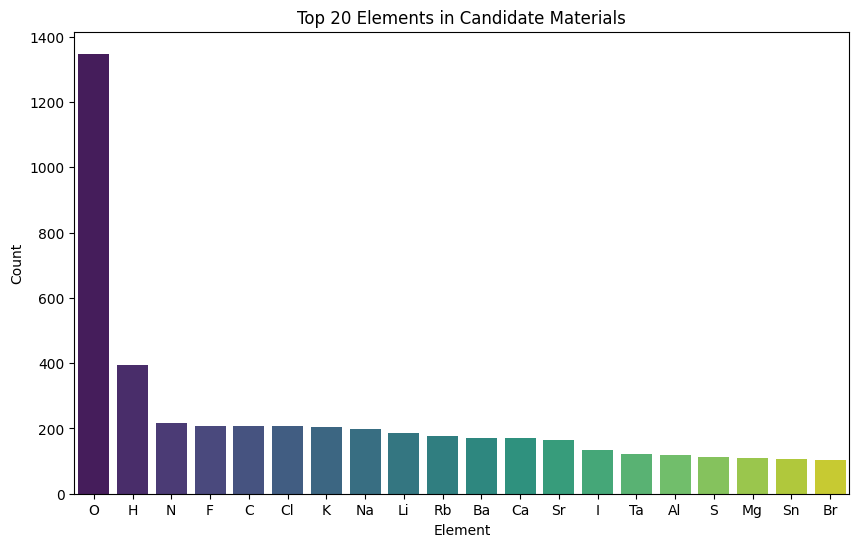

In [9]:
# Element Frequency in Candidates
from collections import Counter

# Split formulas into elements
elements = []
for formula in df_candidates["formula"]:
    # crude split by capital letters
    import re
    elems = re.findall(r'[A-Z][a-z]?', formula)
    elements.extend(elems)

element_counts = Counter(elements)

# Top 20 elements
top_elements = pd.DataFrame(element_counts.most_common(20), columns=["Element", "Count"])

plt.figure(figsize=(10,6))
sns.barplot(data=top_elements, x="Element", y="Count", palette="viridis", hue="Element", legend=False)
plt.title("Top 20 Elements in Candidate Materials")
plt.show()


### Space Group Distribution

Which space groups are most common among transparent semiconductors?

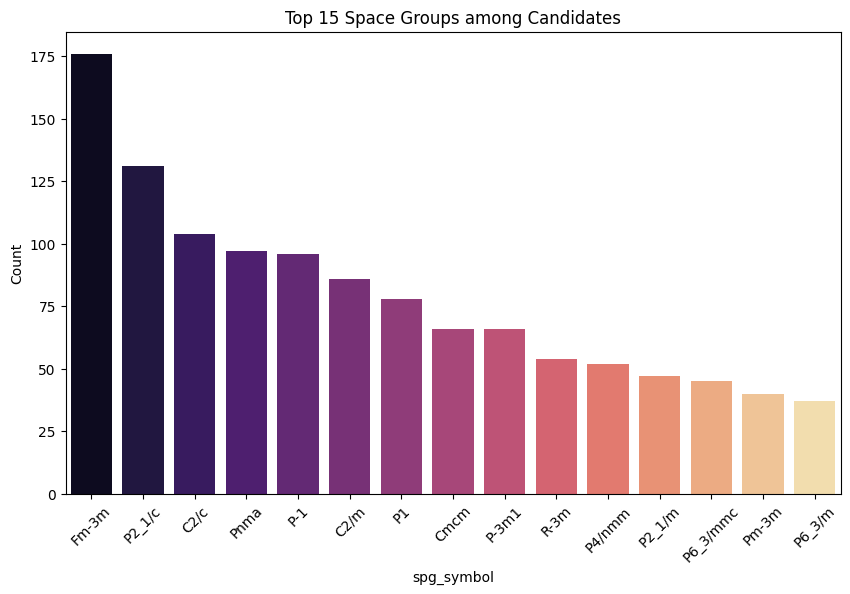

In [10]:
# Space Group Distribution
top_spg = df_candidates["spg_symbol"].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_spg.index, y=top_spg.values, palette="magma",legend=False, hue=top_spg.index )
plt.title("Top 15 Space Groups among Candidates")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


### Stability Ranking

Which candidates combine transparency with negative formation energy (likely stable)?

In [11]:
# Stability Ranking
stable_candidates = df_candidates[df_candidates["formation_energy_peratom"] < 0]
stable_sorted = stable_candidates.sort_values("formation_energy_peratom").head(20)

stable_sorted[["jid", "formula", "optb88vdw_bandgap", "formation_energy_peratom"]]


,jid,formula,optb88vdw_bandgap,formation_energy_peratom
1965,JVASP-153820,ThO2,3.469,-4.08546
32,JVASP-53445,TmPaO4,3.029,-4.01789
299,JVASP-106089,ErPaO4,3.088,-4.01057
1531,JVASP-106327,TbPaO4,3.016,-3.99216
2020,JVASP-145412,Dy3SOF5,3.712,-3.96725
1553,JVASP-111759,Y3SOF5,3.663,-3.96076
1736,JVASP-142387,Sm3SOF5,3.592,-3.93290
1740,JVASP-142398,Nd3SOF5,3.526,-3.91165
541,JVASP-105102,TbOF,3.108,-3.87036
1453,JVASP-57132,Ba2TiOF6,3.802,-3.86524


### Periodic Table Heatmap of Candidate Elements

FIXME!!!  Validate these results

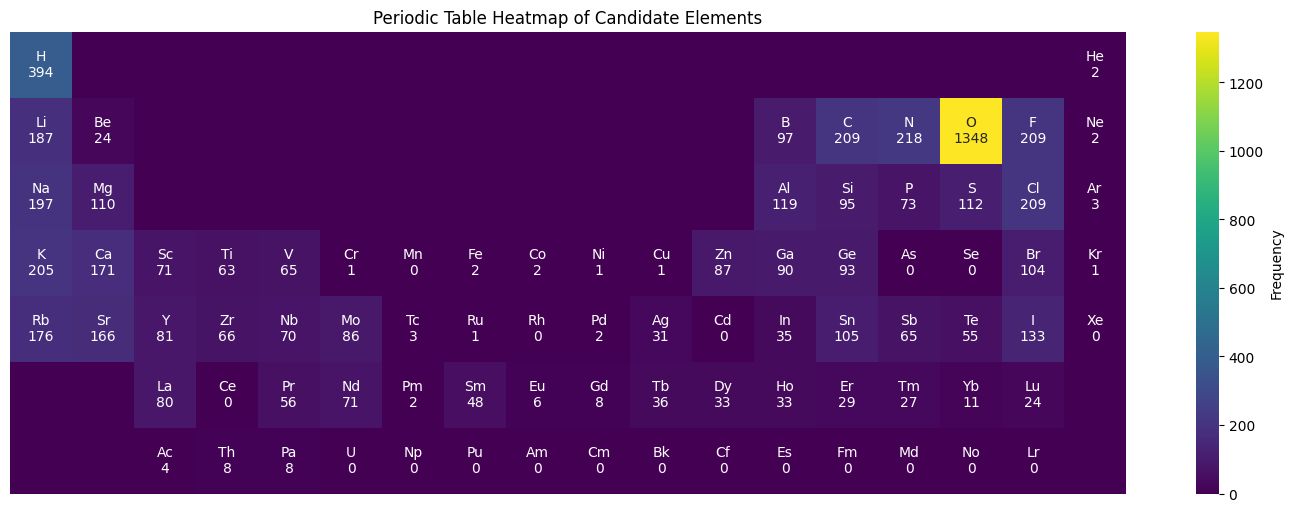

In [12]:
# Periodic Table Heatmap of Candidate Elements
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from collections import Counter

# Extract elements from formulas
elements = []
for formula in df_candidates["formula"]:
    elems = re.findall(r'[A-Z][a-z]?', formula)
    elements.extend(elems)

element_counts = Counter(elements)

# Build periodic table layout
# Periodic table positions (row, col) for first 4 periods
periodic_positions = {
    "H": (0,0), "He": (0,17),
    "Li": (1,0), "Be": (1,1), "B": (1,12), "C": (1,13), "N": (1,14), "O": (1,15), "F": (1,16), "Ne": (1,17),
    "Na": (2,0), "Mg": (2,1), "Al": (2,12), "Si": (2,13), "P": (2,14), "S": (2,15), "Cl": (2,16), "Ar": (2,17),
    "K": (3,0), "Ca": (3,1),
    # Transition metals row 4
    "Sc": (3,2), "Ti": (3,3), "V": (3,4), "Cr": (3,5), "Mn": (3,6), "Fe": (3,7), "Co": (3,8), "Ni": (3,9), "Cu": (3,10), "Zn": (3,11),
    "Ga": (3,12), "Ge": (3,13), "As": (3,14), "Se": (3,15), "Br": (3,16), "Kr": (3,17),
    # Row 5 (Rb-Xe)
    "Rb": (4,0), "Sr": (4,1),
    "Y": (4,2), "Zr": (4,3), "Nb": (4,4), "Mo": (4,5), "Tc": (4,6), "Ru": (4,7), "Rh": (4,8), "Pd": (4,9), "Ag": (4,10), "Cd": (4,11),
    "In": (4,12), "Sn": (4,13), "Sb": (4,14), "Te": (4,15), "I": (4,16), "Xe": (4,17),
    # Lanthanides
    "La": (5,2), "Ce": (5,3), "Pr": (5,4), "Nd": (5,5), "Pm": (5,6), "Sm": (5,7),
    "Eu": (5,8), "Gd": (5,9), "Tb": (5,10), "Dy": (5,11), "Ho": (5,12), "Er": (5,13),
    "Tm": (5,14), "Yb": (5,15), "Lu": (5,16),
    # Actinides
    "Ac": (6,2), "Th": (6,3), "Pa": (6,4), "U": (6,5), "Np": (6,6), "Pu": (6,7),
    "Am": (6,8), "Cm": (6,9), "Bk": (6,10), "Cf": (6,11), "Es": (6,12), "Fm": (6,13),
    "Md": (6,14), "No": (6,15), "Lr": (6,16),
}

# Build heatmap matrix
rows, cols = 7, 18 # Include lanthanides and actinides
heatmap = [[0]*cols for _ in range(rows)]
labels = [[""]*cols for _ in range(rows)]

for elem, (r,c) in periodic_positions.items():
    count = element_counts.get(elem, 0)
    heatmap[r][c] = count
    labels[r][c] = f"{elem}\n{count}"

# Plot heatmap
plt.figure(figsize=(18,6))
sns.heatmap(heatmap, annot=labels, fmt="", cmap="viridis", cbar_kws={'label':'Frequency'})
plt.title("Periodic Table Heatmap of Candidate Elements")
plt.axis("off")
plt.show()


### Use PCA to Visualize candidate

 - Clusters: Use PCA to reveal whether candidate materials cluster by bandgap, density, or formation energy.
 - Variance explained: The explained variance ratio tells you how much of the dataset’s structure is captured in 2D.
 - Chemistry trends: Coloring by bandgap highlights whether transparent candidates form distinct groups.

In [13]:
# Select only numeric columns
numeric_df = df_candidates.select_dtypes(include=[np.number])
print("Numeric features selected:", numeric_df.columns.tolist())

Numeric features selected: ['formation_energy_peratom', 'optb88vdw_bandgap', 'optb88vdw_total_energy', 'ehull', 'density', 'nat']


In [14]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

In [15]:
# Apply PCA 
pca = PCA(n_components=2)  # reduce to 2D for visualization
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.36515441 0.18056145]


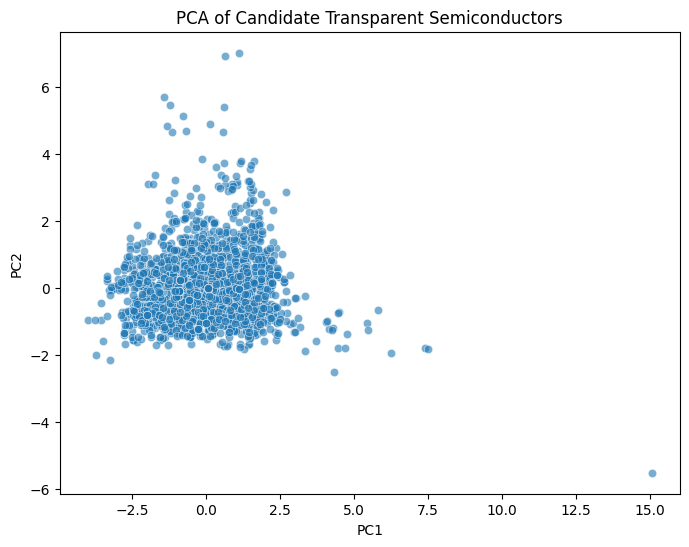

In [16]:
# PCA Scatter Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], alpha=0.6)
plt.title("PCA of Candidate Transparent Semiconductors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

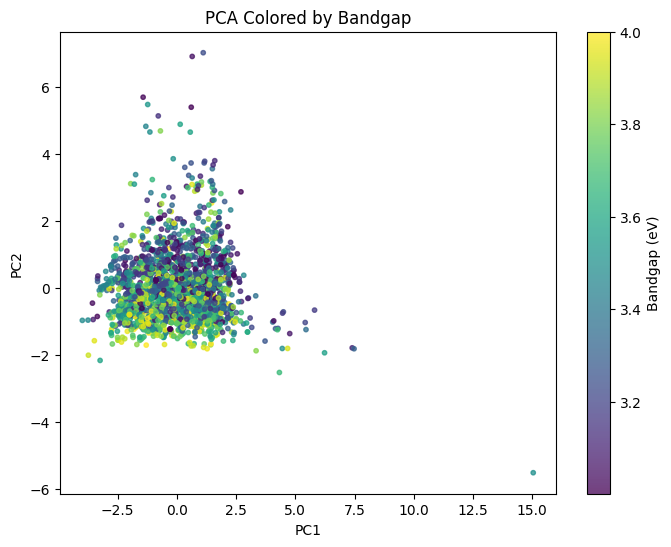

In [17]:
# PCA Scatter Plot (colored by bandgap)
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[:,0], X_pca[:,1],
                 c=df_candidates["optb88vdw_bandgap"],
                 cmap="viridis", alpha=0.75, s=10)
plt.title("PCA Colored by Bandgap")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(sc, label="Bandgap (eV)")
plt.show()


### Explore 3D PCA

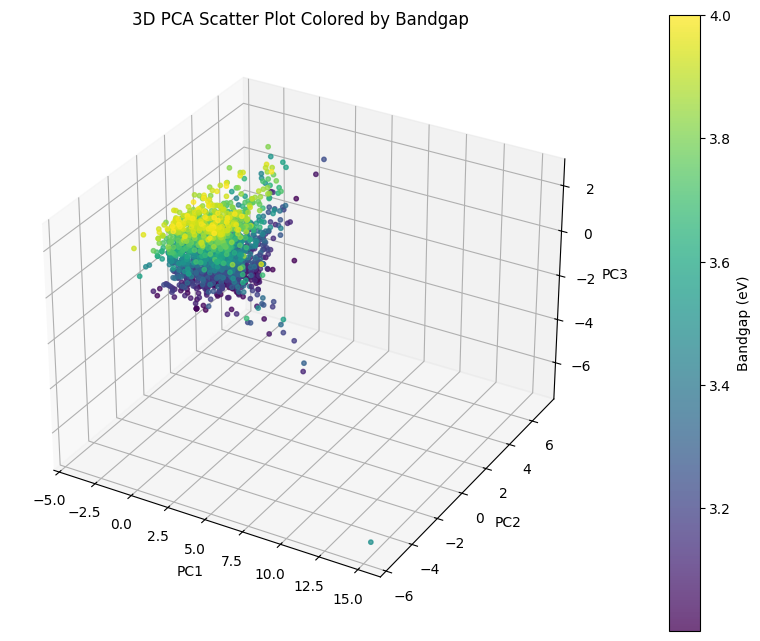

Explained variance ratio (PC1–PC3): [0.36515441 0.18056145 0.16836075]


In [18]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Run PCA with 3 components
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)

# 3D scatter plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2],
                c=df_candidates["optb88vdw_bandgap"],
                cmap="viridis", alpha=0.75, s=10)

ax.set_title("3D PCA Scatter Plot Colored by Bandgap")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Bandgap (eV)")

plt.show()

print("Explained variance ratio (PC1–PC3):", pca3.explained_variance_ratio_)


In [19]:
import plotly.express as px
from sklearn.decomposition import PCA

# Run PCA with 3 components
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)

# Build DataFrame for plotting
pca_df = pd.DataFrame(X_pca3, columns=["PC1", "PC2", "PC3"])
pca_df["bandgap"] = df_candidates["optb88vdw_bandgap"].values
pca_df["formula"] = df_candidates["formula"].values
pca_df["jid"] = df_candidates["jid"].values

# Interactive 3D scatter plot
fig = px.scatter_3d(
    pca_df,
    x="PC1", y="PC2", z="PC3",
    color="bandgap",
    hover_data=["jid", "formula", "bandgap"],
    color_continuous_scale="Viridis",
    title="Interactive 3D PCA Scatter Plot Colored by Bandgap"
)

fig.update_traces(marker=dict(size=4, opacity=0.7))
fig.show()

print("Explained variance ratio (PC1–PC3):", pca3.explained_variance_ratio_)


Explained variance ratio (PC1–PC3): [0.36515441 0.18056145 0.16836075]


### Visualize a Candidate

In [20]:
import ast
from jarvis.core.atoms import Atoms
from ase.visualize import view

# Ensure clean copy and reset index
df_candidates = df_candidates.copy().reset_index(drop=True)

# Add atoms_obj column
df_candidates["atoms_obj"] = df_candidates["atoms"].apply(
    lambda x: Atoms.from_dict(ast.literal_eval(x)) if isinstance(x, str) else Atoms.from_dict(x)
)

# Access first candidate
a = df_candidates.loc[0, "atoms_obj"]
print(a)


System
1.0
3.93712543178282 0.0 2.273100275741533
1.3123751439276066 3.7119571065192623 2.273100275741533
0.0 0.0 4.546200551483066
Na I 
1 1 
direct
0.0 0.0 0.0 Na
0.5 0.5 0.5 I



In [21]:
from ase.visualize import view
view(a.ase_converter(),viewer='x3d')

## General Dataframe Exploration

see also: https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Analyzing_data_in_the_JARVIS_DFT_dataset.ipynb


In [22]:
# Keys in the json file
print (df.columns, len(df.columns))

Index(['jid', 'spg_number', 'spg_symbol', 'formula',
       'formation_energy_peratom', 'func', 'optb88vdw_bandgap', 'atoms',
       'slme', 'magmom_oszicar', 'spillage', 'elastic_tensor',
       'effective_masses_300K', 'kpoint_length_unit', 'maxdiff_mesh',
       'maxdiff_bz', 'encut', 'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz',
       'mepsx', 'mepsy', 'mepsz', 'modes', 'magmom_outcar', 'max_efg',
       'avg_elec_mass', 'avg_hole_mass', 'icsd', 'dfpt_piezo_max_eij',
       'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'efg', 'xml_data_link', 'typ', 'exfoliation_energy', 'spg', 'crys',
       'density', 'poisson', 'raw_files', 'nat', 'bulk_modulus_kv',
       'shear_modulus_gv', 'mbj_bandgap', 'hse_ga

In [23]:
df.head()

,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,density,poisson,raw_files,nat,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search
0,JVASP-90856,129,P4/nmm,TiCuSiAs,-0.42762,OptB88vdW,0.000,"{'lattice_mat': [[3.566933224304235, 0.0, -0.0...",na,0.0,...,5.956,na,[],8,na,na,na,na,mp-1080455,-As-Cu-Si-Ti
1,JVASP-86097,221,Pm-3m,DyB6,-0.41596,OptB88vdW,0.000,"{'lattice_mat': [[4.089078911208881, 0.0, 0.0]...",na,0.0,...,5.522,na,"[OPT-LOPTICS,JVASP-86097.zip,https://ndownload...",7,na,na,na,na,mp-568319,-B-Dy
2,JVASP-64906,119,I-4m2,Be2OsRu,0.04847,OptB88vdW,0.000,"{'lattice_mat': [[-1.833590720595598, 1.833590...",na,0.0,...,10.960,na,"[OPT-LOPTICS,JVASP-64906.zip,https://ndownload...",4,na,na,na,na,auid-3eaf68dd483bf4f4,-Be-Os-Ru
3,JVASP-98225,14,P2_1/c,KBi,-0.44140,OptB88vdW,0.472,"{'lattice_mat': [[7.2963518353359165, 0.0, 0.0...",na,0.0,...,5.145,na,[],32,na,na,na,na,mp-31104,-Bi-K
4,JVASP-10,164,P-3m1,VSe2,-0.71026,OptB88vdW,0.000,"{'lattice_mat': [[1.6777483798834445, -2.90594...",na,0.0,...,5.718,0.23,"[FD-ELAST,JVASP-10.zip,https://ndownloader.fig...",3,48.79,33.05,0.0,na,mp-694,-Se-V


In [24]:
# Count number of entries for each property
for i in df.columns.values:
  val=df[i].replace('na',pd.NA).dropna().values
  print(i,len(val))

jid 75993
spg_number 75993
spg_symbol 75993
formula 75993
formation_energy_peratom 75993
func 75993
optb88vdw_bandgap 75993
atoms 75993
slme 9770
magmom_oszicar 71320
spillage 11377
elastic_tensor 25513
effective_masses_300K 75993
kpoint_length_unit 75671
maxdiff_mesh 5861
maxdiff_bz 5861
encut 75670
optb88vdw_total_energy 75993
epsx 52168
epsy 52168
epsz 52168
mepsx 18293
mepsy 18293
mepsz 18293
modes 13910
magmom_outcar 74261
max_efg 11871
avg_elec_mass 17645
avg_hole_mass 17645
icsd 75993
dfpt_piezo_max_eij 4799
dfpt_piezo_max_dij 3347
dfpt_piezo_max_dielectric 4706
dfpt_piezo_max_dielectric_electronic 4809
dfpt_piezo_max_dielectric_ionic 4809
max_ir_mode 4805
min_ir_mode 4809
n-Seebeck 23218
p-Seebeck 23218
n-powerfact 23218
p-powerfact 23218
ncond 23218
pcond 23218
nkappa 23218
pkappa 23218
ehull 75993
Tc_supercon 1058
dimensionality 75560
efg 75993
xml_data_link 75993
typ 75993
exfoliation_energy 813
spg 75993
crys 75993
density 75993
poisson 23597
raw_files 75993
nat 75993
bulk_

In [25]:
# Histogram for select material-properties in the dataset

def show_histograms(df):
    the_grid = GridSpec(4, 3)
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(16,14))

    plt.subplot(the_grid[0, 0])
    val=np.array(df['formation_energy_peratom'].replace('na',pd.NA).dropna().values,dtype='float')

    plt.hist(val,bins=np.arange(-4,3,.1))
    plt.xlabel('Formation enrgies (eV/atom)')
    plt.ylabel('Materials distribution')

    plt.subplot(the_grid[0, 1])
    val=np.array(df['optb88vdw_bandgap'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(0,8,.1))
    plt.xlabel('OptB88vdW bandgaps (eV)')
    #plt.ylabel('Materials distribution')

    plt.subplot(the_grid[0, 2])
    val=np.array(df['mbj_bandgap'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(0,8,.1))
    plt.xlabel('TBmBJ bandgaps (eV)')
    #plt.ylabel('Materials distribution')

    plt.subplot(the_grid[1, 0])
    val=np.array(df['bulk_modulus_kv'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(0,250,10))
    plt.xlabel('Voigt-bulk modulus (GPa)')
    #plt.ylabel('Materials distribution')


    plt.subplot(the_grid[1, 1])
    val=np.array(df['spillage'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(0,4,.1))
    plt.xlabel('Spin-orbit spillage')
    #plt.ylabel('Materials distribution')

    plt.subplot(the_grid[1, 2])
    val=np.array(df['slme'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(0,35,1))
    plt.xlabel('Solar-SLME (%)')
    #plt.ylabel('Materials distribution')


    plt.subplot(the_grid[2, 0])
    val=np.array(df['dfpt_piezo_max_dielectric'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(0,50,2))
    #plt.ylabel('Materials distribution')
    plt.xlabel('Max.Piezo.coeff(C/m2)')


    plt.subplot(the_grid[2, 1])
    val=np.array(df['n-powerfact'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(0,4000,50))
    #plt.ylabel('Materials distribution')
    plt.xlabel('n-Power factor (muW/(mK)2)')

    plt.subplot(the_grid[2, 2])
    val=np.array(df['n-Seebeck'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(-600,0,50))
    #plt.ylabel('Materials distribution')
    plt.xlabel('n-Seebeck coeff (muV/K)')


    plt.subplot(the_grid[3, 0])
    val=np.array(df['magmom_oszicar'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(0,20,1))
    #plt.ylabel('Materials distribution')
    plt.xlabel('Mag.mom (muB)')


    plt.subplot(the_grid[3, 1])
    val=np.array(df['encut'].replace('na',pd.NA).dropna().values,dtype='float')
    plt.hist(val,bins=np.arange(400,1500,50))
    #plt.ylabel('Materials distribution')
    plt.xlabel('ENCUT (eV)')



    plt.subplot(the_grid[3, 2])
    val=np.sqrt(np.array(df['epsx'].replace('na',pd.NA).dropna().values,dtype='float'))
    plt.hist(val,bins=np.arange(0,25,1))
    #plt.ylabel('Materials distribution')
    plt.xlabel('OptB88vdW Refractive index-x')

    plt.tight_layout()

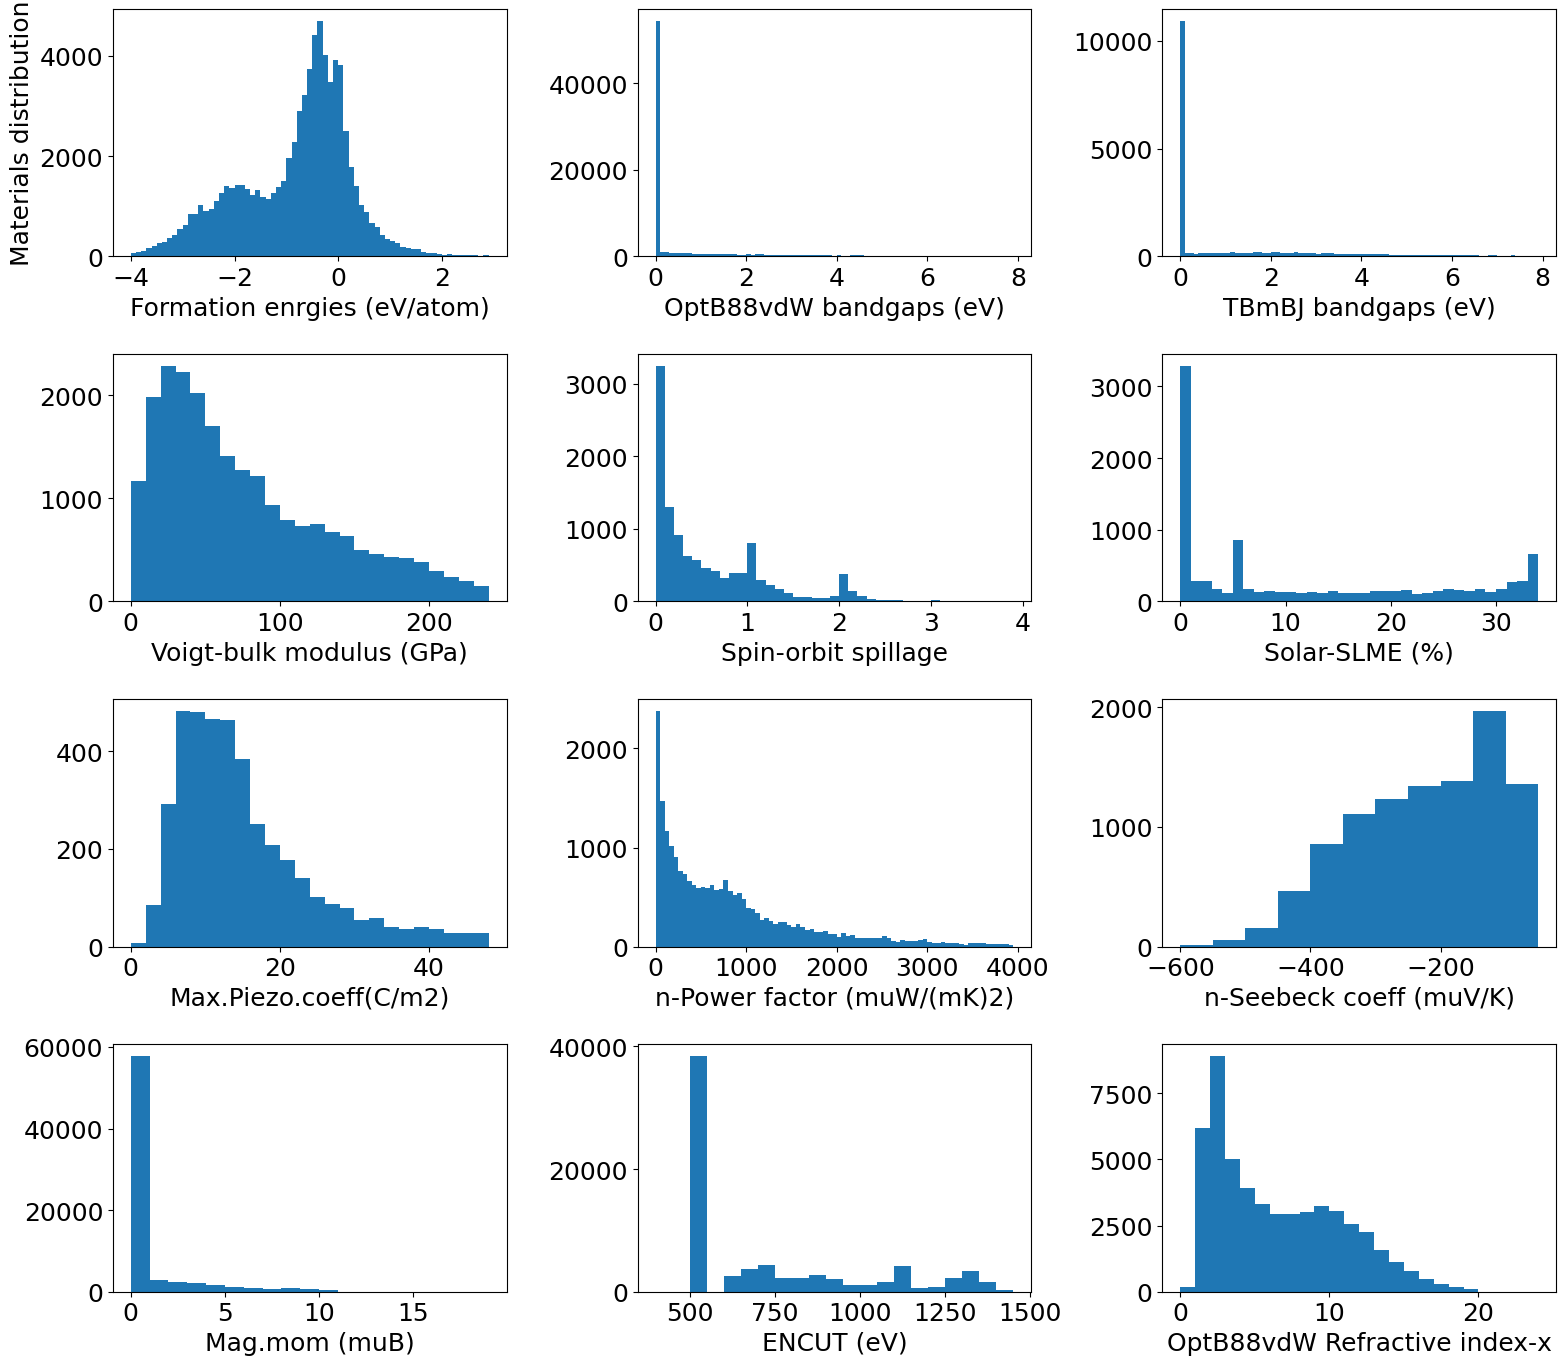

In [26]:
show_histograms(df)

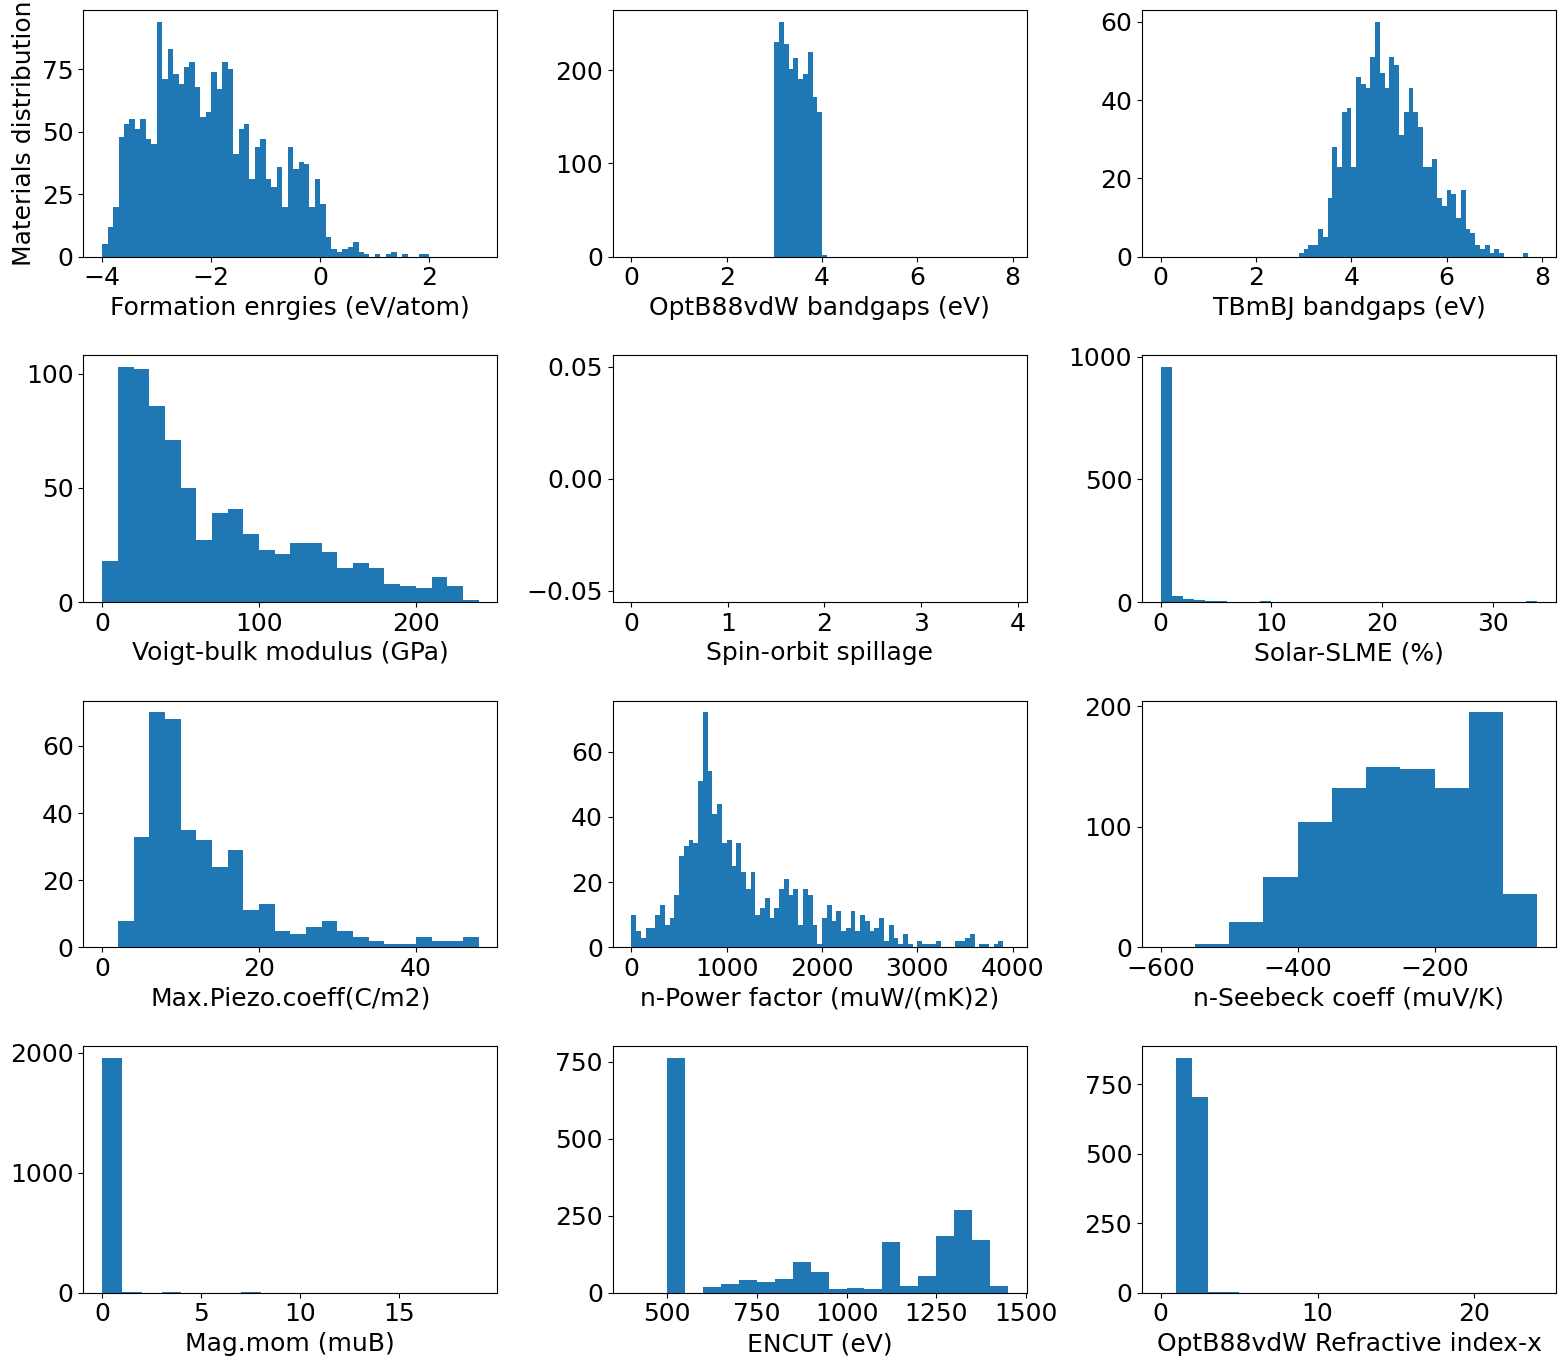

In [27]:
show_histograms(df_candidates)

In [28]:
df.iloc[0]['atoms']

{'lattice_mat': [[3.566933224304235, 0.0, -0.0],
  [0.0, 3.566933224304235, -0.0],
  [-0.0, -0.0, 9.397075454186664]],
 'coords': [[2.6751975000000003, 2.6751975000000003, 7.376101754328542],
  [0.8917325, 0.8917325, 2.0209782456714573],
  [0.8917325, 2.6751975000000003, 4.69854],
  [2.6751975000000003, 0.8917325, 4.69854],
  [0.8917325, 2.6751975000000003, 0.0],
  [2.6751975000000003, 0.8917325, 0.0],
  [2.6751975000000003, 2.6751975000000003, 2.8894795605846353],
  [0.8917325, 0.8917325, 6.507600439415366]],
 'elements': ['Ti', 'Ti', 'Cu', 'Cu', 'Si', 'Si', 'As', 'As'],
 'abc': [3.56693, 3.56693, 9.39708],
 'angles': [90.0, 90.0, 90.0],
 'cartesian': True,
 'props': ['', '', '', '', '', '', '', '']}

In [29]:
df.iloc[0][['epsx', 'epsy', 'epsz']]

epsx      76.23
epsy      76.23
epsz    54.0402
Name: 0, dtype: object

In [30]:
# Define known transparent semiconductor formulas
transparent_formulas = [
    "In2O3", "ZnO", "SnO2", "Ga2O3", "TiO2", "SrTiO3", "BaSnO3", "SrVO3",
    "Al2O3", "SiO2", "MgO", "GaN", "SiC"
]

# Search DataFrame for matches
df_transparent_known = df[df["formula"].isin(transparent_formulas)].copy()

logger.info(f"Known transparent semiconductors found: {df_transparent_known.shape[0]}")
#print(df_transparent_known[["jid", "formula", "optb88vdw_bandgap"]])
logger.info("\n%s", df_transparent_known[["jid", "formula", "optb88vdw_bandgap"]].to_string());
flush_logger(logger)

2025-11-18 20:46:04,420 - jarvis_project - INFO - Known transparent semiconductors found: 218
2025-11-18 20:46:04,427 - jarvis_project - INFO - 
                jid formula  optb88vdw_bandgap
247     JVASP-22644     SiC              2.273
539     JVASP-97862    SiO2              5.621
596     JVASP-49837   Al2O3              4.737
935     JVASP-97444    SiO2              5.205
1175       JVASP-32   Al2O3              6.430
1683    JVASP-42549    TiO2              2.665
2078    JVASP-98776    SiO2              5.765
2168    JVASP-98531    SiO2              5.692
2272    JVASP-98532    SiO2              5.497
2476    JVASP-90247    TiO2              0.951
2906    JVASP-97419    SnO2              0.964
3031    JVASP-97332    SiO2              5.644
3212    JVASP-97422    SiO2              5.630
3367    JVASP-97720    SiO2              0.000
3564    JVASP-85600   Al2O3              1.213
4124    JVASP-86325  BaSnO3              0.578
4175    JVASP-88050    SiO2              5.603
4366    J

## Baseline Model

In [31]:


# --- Utilities ---

def coerce_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


def drop_empty_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drop columns that are entirely NaN if numeric. Keep object columns (categorical)
    and any column with at least one non-missing numeric value.
    """
    keep = []
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            if df[col].notna().any():
                keep.append(col)
        else:
            # keep non-numeric only if categorical (object)
            if df[col].dtype == "object":
                keep.append(col)
    return df[keep]

def flatten_dict_column(df, col, prefix):
    """
    Expand a dict-like column into separate numeric columns.
    """
    expanded = df[col].apply(lambda d: d if isinstance(d, dict) else {})
    expanded_df = pd.json_normalize(expanded)
    expanded_df = expanded_df.add_prefix(f"{prefix}_")
    return pd.concat([df.drop(columns=[col]), expanded_df], axis=1)

def safe_list_stats(lst):
    """Compute mean/std/min/max for a list, ignoring non-numeric entries."""
    if not isinstance(lst, (list, tuple)) or len(lst) == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    nums = []
    for x in lst:
        if isinstance(x, (int, float, np.number)):
            nums.append(float(x))
        else:
            try:
                nums.append(float(x))
            except (ValueError, TypeError):
                continue
    if len(nums) == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    return (np.mean(nums), np.std(nums), np.min(nums), np.max(nums))

def flatten_list_column(df, col, prefix):
    """
    Flatten a list-like column into numeric summary stats using safe_list_stats.
    """
    stats = df[col].apply(safe_list_stats)
    df[f"{prefix}_mean"] = stats.apply(lambda t: t[0])
    df[f"{prefix}_std"]  = stats.apply(lambda t: t[1])
    df[f"{prefix}_min"]  = stats.apply(lambda t: t[2])
    df[f"{prefix}_max"]  = stats.apply(lambda t: t[3])
    return df.drop(columns=[col])

def sanitize_features(df: pd.DataFrame, drop_cols=None) -> pd.DataFrame:
    """
    Two-pass sanitizer:
    1) Flatten dict-like columns across the entire frame.
    2) Flatten list-like columns across the entire frame.
    Drop structural columns listed in drop_cols first.
    """
    if drop_cols:
        df = df.drop(columns=drop_cols, errors="ignore")

    # Pass 1: flatten dicts everywhere
    for col in list(df.columns):
        if df[col].apply(lambda v: isinstance(v, dict)).any():
            df = flatten_dict_column(df, col, col)

    # Pass 2: flatten lists everywhere (after dict flattening)
    for col in list(df.columns):
        if df[col].apply(lambda v: isinstance(v, (list, tuple))).any():
            df = flatten_list_column(df, col, col)

    return df

def drop_residual_non_scalars(df: pd.DataFrame) -> pd.DataFrame:
    """
    Final sweep: drop any columns that still contain lists or dicts.
    """
    to_drop = []
    for col in df.columns:
        if df[col].apply(lambda v: isinstance(v, (list, tuple, dict))).any():
            to_drop.append(col)
    return df.drop(columns=to_drop, errors="ignore")

# --- Feature builder and modeling ---

def build_features(df: pd.DataFrame, config: dict) -> pd.DataFrame:
    df = df.copy()

    # Transparency label from config threshold
    bandgap_col = config["filters"]["bandgap_column"]
    trans_min   = config["filters"]["transparent_min"]
    df["is_transparent"] = pd.to_numeric(df[bandgap_col], errors="coerce") > trans_min

    # Dielectric features
    for c in ["epsx", "epsy", "epsz"]:
        if c not in df.columns:
            df[c] = np.nan
        else:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df["eps_mean"] = df[["epsx","epsy","epsz"]].mean(axis=1, skipna=True)
    df["eps_std"]  = df[["epsx","epsy","epsz"]].std(axis=1, skipna=True)

    # Flatten known dict-like
    if "effective_masses_297K" in df.columns:
        df["electron_mass"] = df["effective_masses_297K"].apply(
            lambda d: d.get("electron_mass") if isinstance(d, dict) else np.nan
        )
        df["hole_mass"] = df["effective_masses_297K"].apply(
            lambda d: d.get("hole_mass") if isinstance(d, dict) else np.nan
        )
        df = df.drop(columns=["effective_masses_297K"])

    # Flatten known list-like
    for col in ["effective_masses_300K_p", "effective_masses_300K_n"]:
        if col in df.columns:
            df = flatten_list_column(df, col, col)

    # Possible dict wrappers for averages
    for col in ["avg_elec_mass", "avg_hole_mass"]:
        if col in df.columns:
            df[col] = df[col].apply(lambda d: d.get("value") if isinstance(d, dict) else d)
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Bag-of-elements
    if config["features"].get("bag_of_elements", True):
        element_set = ["O","N","F","Al","Ga","In","Zn","Sn","Mg","Ti","Si","C"]
        for el in element_set:
            df[f"has_{el}"] = df["formula"].str.contains(rf"\b{el}\b", regex=True, na=False).astype(int)

    # Sanitize broadly, drop structural artifacts
    df = sanitize_features(df, drop_cols=["atoms", "elastic_tensor", "raw_files"])

    # Final sweep to remove any residual non-scalars
    df = drop_residual_non_scalars(df)

    # Drop empty numeric features
    df = drop_empty_features(df)

    return df

def split_train_val_known(df: pd.DataFrame, config: dict):
    known_list = set(config["known"]["transparent_formulas"])
    in_known = df["formula"].isin(known_list)
    df_known = df[in_known].copy()
    df_main  = df[~in_known].copy()

    X = df_main.drop(columns=config["ml"]["exclude_columns"])
    y = df_main[config["ml"]["target_column"]].astype(int)

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    return (X_train, X_val, y_train, y_val), df_known


In [32]:
def build_baseline_pipeline(X_train: pd.DataFrame, config: dict):
    # Explicitly separate numeric vs categorical
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ])
    categorical = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preproc = ColumnTransformer(
        transformers=[
            ("num", numeric, numeric_cols),
            ("cat", categorical, cat_cols)
        ],
        remainder="drop"
    )

    model_choice = config["ml"].get("model", "logreg")
    if model_choice == "logreg":
        clf = LogisticRegression(max_iter=500, class_weight="balanced")
    else:
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)

    pipeline = Pipeline(steps=[("preproc", preproc), ("clf", clf)])
    return pipeline

In [ ]:
# --- Usage & testing ---

df_feat = build_features(df, config)

# Coerce known numeric-like columns to numeric
numeric_like = ["spg_number", "encut", "poisson", "bulk_modulus_kv", "shear_modulus_gv", "exfoliation_energy"]
df_feat = coerce_numeric(df_feat, numeric_like)

# Diagnostics: ensure no lists/dicts remain
exclude = config["ml"]["exclude_columns"]
target = config["ml"]["target_column"]
cols_to_check = [c for c in df_feat.columns if c not in exclude and c != target]

residual_lists = [c for c in cols_to_check if df_feat[c].apply(lambda v: isinstance(v, (list, tuple))).any()]
residual_dicts = [c for c in cols_to_check if df_feat[c].apply(lambda v: isinstance(v, dict)).any()]
print("Residual list columns:", residual_lists)
print("Residual dict columns:", residual_dicts)
assert len(residual_lists) == 0 and len(residual_dicts) == 0, "Non-scalar columns remain after sanitization."

# Split train/val and known holdout
(X_train, X_val, y_train, y_val), df_known = split_train_val_known(df_feat, config)

# Force categorical columns to string type
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
for c in cat_cols:
    X_train[c] = X_train[c].astype(str)
    X_val[c] = X_val[c].astype(str)
    if c in df_known.columns:
        df_known[c] = df_known[c].astype(str)

# Drop High‑Cardinality Categorical Columns
high_cardinality = ["xml_data_link", "reference", "search", "icsd"]
df = df.drop(columns=high_cardinality, errors="ignore")

# Diagnostics: show numeric vs categorical split
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# High‑Cardinality Categorical Features
# Use Frequency/Target Encoding Instead of OneHot Encoding for remaining
for col in cat_cols:
    if df[col].nunique() > 50:  # threshold
        freqs = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freqs)
print("Numeric feature columns:", numeric_cols)
print("Categorical feature columns:", cat_cols)

# Build pipeline with categorical encoding
pipe = build_baseline_pipeline(X_train, config)

Residual list columns: []
Residual dict columns: []
Numeric feature columns: ['spg_number', 'formation_energy_peratom', 'encut', 'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'avg_elec_mass', 'avg_hole_mass', 'ehull', 'exfoliation_energy', 'density', 'poisson', 'nat', 'bulk_modulus_kv', 'shear_modulus_gv', 'eps_mean', 'eps_std', 'has_O', 'has_N', 'has_F', 'has_Al', 'has_Ga', 'has_In', 'has_Zn', 'has_Sn', 'has_Mg', 'has_Ti', 'has_Si', 'has_C', 'modes_mean', 'modes_std', 'modes_min', 'modes_max', 'effective_masses_300K_p_mean', 'effective_masses_300K_p_std', 'effective_masses_300K_p_min', 'effective_masses_300K_p_max', 'effective_masses_300K_n_mean', 'effective_masses_300K_n_std', 'effective_masses_300K_n_min', 'effective_masses_300K_n_max']
Categorical feature columns: ['spg_symbol', 'func', 'slme', 'magmom_oszicar', 'spillage', 'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'mepsx', 'mepsy', 'mepsz', 'magmom_outcar', 'max_efg', 'icsd', 'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij

In [34]:
# Fit and evaluate
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print("\nValidation performance:")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

# External evaluation on known transparent formulas
X_known = df_known.drop(columns=config["ml"]["exclude_columns"])
y_known = df_known["is_transparent"].astype(int)
y_known_pred = pipe.predict(X_known)

print("\nExternal evaluation (known formulas):")
print(classification_report(y_known, y_known_pred))
print(confusion_matrix(y_known, y_known_pred))

: 

In [ ]:
for col in X_train.columns:
    if X_train[col].apply(lambda v: isinstance(v, list)).any():
        print("Lists found in:", col)

Lists found in: effective_masses_300K_p
Lists found in: effective_masses_300K_n
